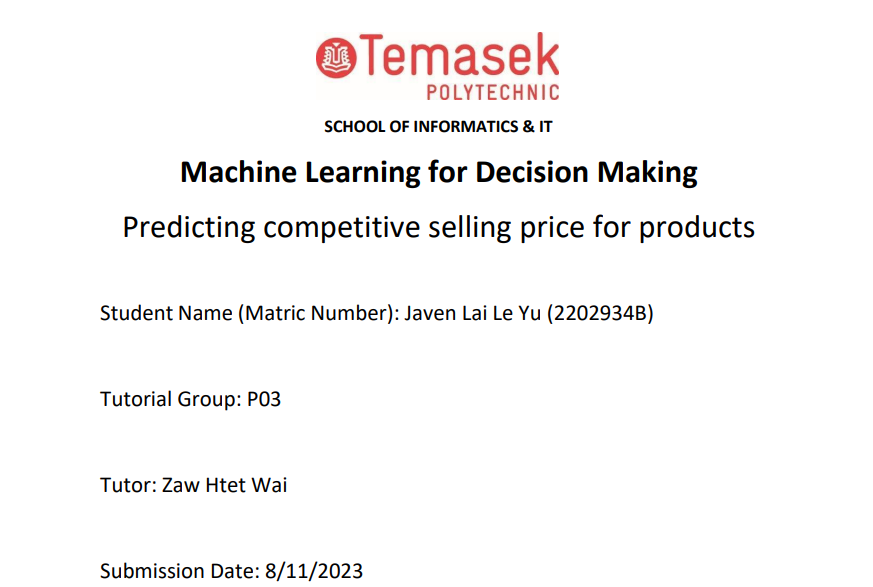
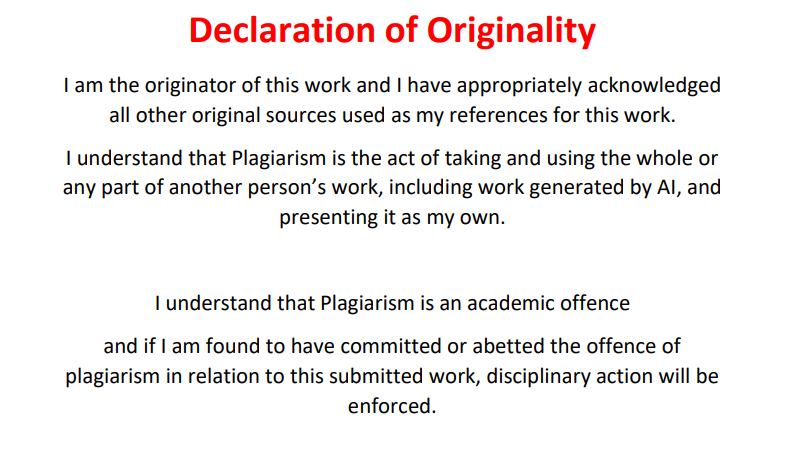
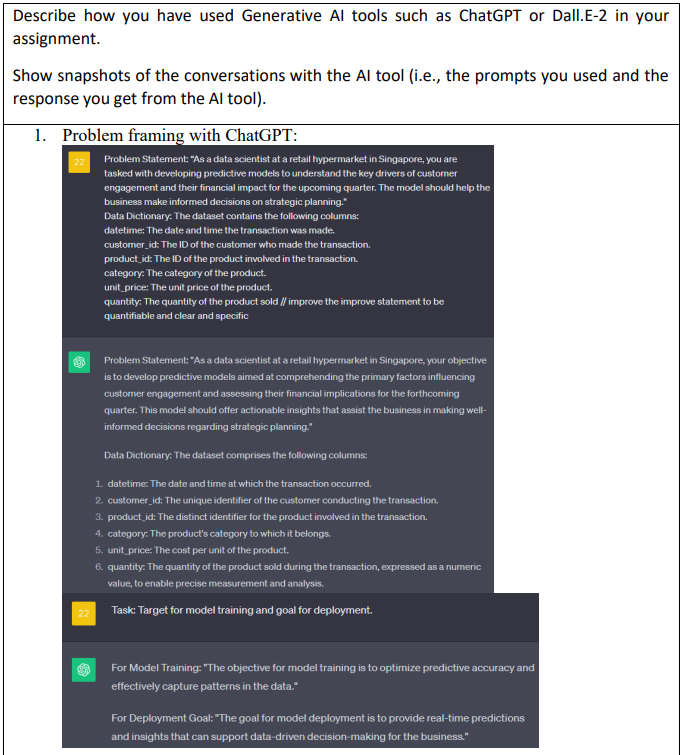
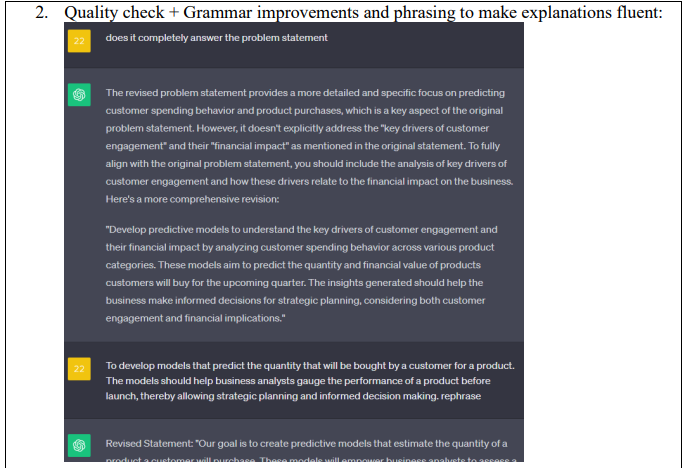
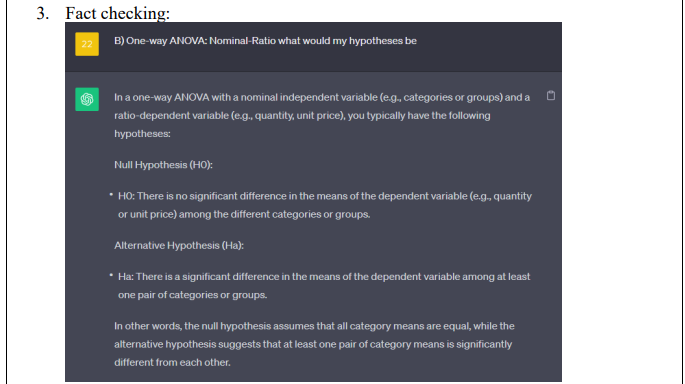
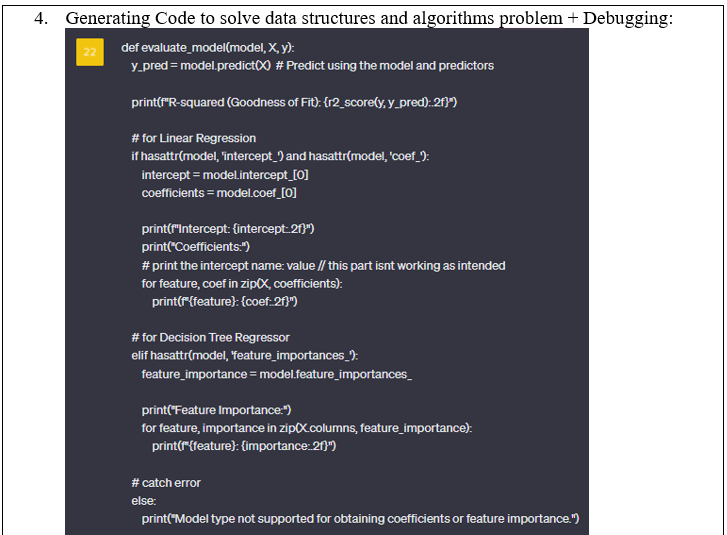
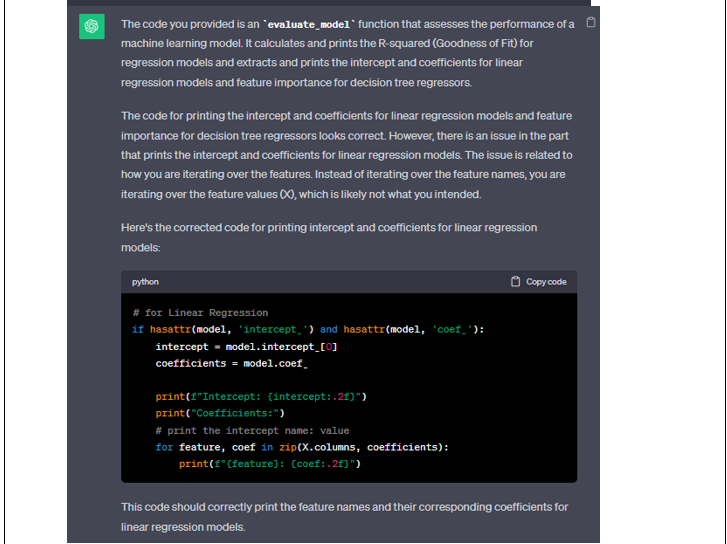
#### All retrievable conversations with ChatGPT:
- https://chat.openai.com/share/2f07b504-cdc7-4af6-b3f9-1803397adb77 
- https://chat.openai.com/share/eac1cc39-e944-4509-9d54-e08c52ca58b7 
- https://chat.openai.com/share/6aa8965f-4bbc-4cc2-8abf-5d1603f324c2 
- https://chat.openai.com/share/cf90d57b-8425-4502-a871-71a0a8c3d06e 

## 1. Introduction

### 1.0 Business Context
Retail Hypermarket is a Singapore-based store that has a business model of pricing products at a competitive price. For the last 2 years, they tried strategies like giving discounts for bulk purchases, loyalty points, cross-selling, and upselling. However, they are unsure about the efficacy of such strategies as they do not know how to analyse their transactional data. 

I have been engaged as a data scientist to **understand their customer engagement and financial performance**, to develop a one-stop solution that assists them with future decision-making.

### 1.1 Problem Statement
To develop predictive models that account factors like customer type, volume of purchase, and market trends to **determine the most reasonable pricing for a product** for the next quarter of the year based on historical transactions.

### 1.2 Objective
The models are trained to **predict the unit price of a product for a transaction** based on customer behaviour (bulk purchaser, loyal customer, etc.) and which quarter of the year the transaction occurs during.

### 1.3 Goal for deployment
1.3.1 Whitebox:
- Highly interpretable and rationale behind how the model derives a prediction can be clearly understood.
- Model fit should be above 80%, to affirm model is reliable and its decisions are closely based off truth of historical data; no underfitting.

1.3.2 Blackbox:
- Predictions are highly accurate.
- Rationale behind how the model derives its prediction can be understood.
- Model fit should be above 80%, to affirm model is reliable and its decisions are closely based off truth of historical data; no underfitting.

### 1.4 Inputs for Models
Target: Unit Price

Predictors:
- Product type
- Customer type
- Product features
- Quantity of purchase
- Quarter

### 1.5 Considerations
- Predictors should be readily available before occurrence of prediction.
- Data used to train models should be recent, to ensure the patterns and intricacies the model works on matches the current trend. This makes the model usable as the predictions are reliable.
- Models should be well-generalized to predict unseen future occurrences with similar accuracy as training dataset; no overfitting on training data.
- Models should adhere to AI ethics and regulations, ensuring transparency, fairness, absence of bias, and non-discrimination.

### 1.6 Metrics for Model Evaluation
1.6.1 **Goodness of Fit: R^2** to analyse how well to predictions can be explained by the predictor values, to assess if the patterns and intricacies of how customers engage in purchase of various products has been captured by model.

1.6.2 **Accuracy: Mean Absolute Percentage Error (MAPE)** to assess the accuracy percentage of an average prediction compared to the actual value. 

As unit price can range from cents to thousands of dollars, MAPE is the most suitable measure for assessing the accuracy of a model's prediction in a clear and meaningful way for the nature of the models' target because it provides a relative measure of prediction accuracy, rather than a definitive error value to fit all ranges of prediction.

### 1.7 Success Criteria for Project
- Deploy **1** white-box and **1** black-box model to be presented to Retail Hypermarket for usage.
- Before deployment, MAPE should be below 30%, indicating a prediction accuracy of at least 70%, which is considered acceptable for business usage.
- The black-box model should outperform the white-box model by a noticeable margin of minimally 5%, ensuring the choice of the more complex model is justified by significantly improved accuracy.

### 1.8 Environment
- New Products and Customers:
The model should also work for new products and customers not in training dataset. This ensures usability of models for the future.

- Economic Status:
Customer interests and spending behaviour may change during recessions or economic boom. These trends may not be captured and identified if they are not within the training dataset.

- Market Trends:
The market trend can change rapidly in this fast-paced society, and may differ from the training data.

- Seasonal changes:
In the event of an unprecedented intense rainfall or scorching weather period, these weather may deter customers from going to to shop at our stores, resulting financial performance that cannot be explained by the models.

- Competition:
New retail companies may emerge in the future and influence our customers' decision in choosing our store and the models are unable to account for such external factors.

#### In summary:
It's important that the training dataset is recent and reflective of current trends and customer behaviour.


### 1.9 Target leakage
#### Do not include:
- **Features not available at the time of prediction** as this makes the model unusable as the business would not have access to such information when making pricing decisions.
- **Features directly related unit price** to prevent multicollinearity issues.
- **Features with unrealistically high collinearity with unit price**, which could be derived from the target and bias the model.
- **High cardinality columns** like ID to prevent overfitting and ensure model generalization with new, unseen data.

## 2. Data Attributes

### 2.1 Data Understanding
The dataset 'synthetic_data.csv' was provided by Retail Hypermarket, which contains the company's transaction records from 2021 to 2022. A data dictionary, attached below, has also been provided for understanding what each column represents.

> 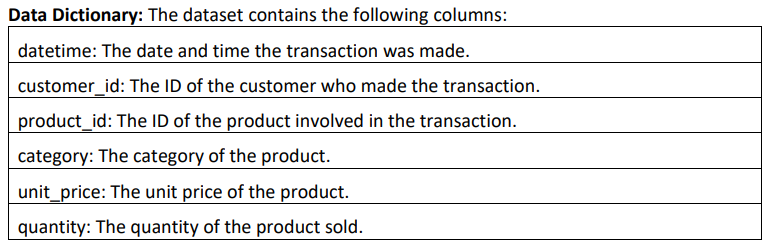

### 2.2 Data Inspection
#### 2.2.1 Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 2202934 # random state

#### 2.2.2 Loading csv into DataFrame

In [2]:
df = pd.read_csv('synthetic_data.csv')
print("Number of observations: ", len(df))

Number of observations:  331664


There is sufficient data of 300K+ rows for train test splitting.

#### 2.2.3 Exploring Dataset

In [3]:
pd.set_option('display.float_format', '{:.10f}'.format) # show full unit_price without truncation
df.head()

,Datetime,Product_ID,Category,Quantity,Unit_Price,Customer_ID
0,2022-01-07,10106959,Stationery,9,1.5798753892,a225207859
1,2022-01-09,90097406,Sports,4,196.2533774599,a225207859
2,2022-01-10,10010465,Electronics,1,825.3742907058,a225207859
3,2022-01-14,10010510,Electronics,2,325.9650346646,a225207859
4,2022-01-16,40049430,Books,1,22.6019194627,a225207859


#### Evaluation:
1. **Datetime is missing time**. There is nothing that can be done about missing time as I am only provided with this dataset.


2. There is **no columns like Quarter or Month**. However, these seasonality features can be derived from the date in Datetime.


3. Unit_Price is a non-terminating number, which is strange as its unconventional for prices at supermarkets to go beyond cents.

Hence, **Unit_Price should be rounded off to 2 d.p.**

#### 2.2.4 Are there duplicated records?

In [4]:
df.duplicated(subset=['Datetime', 'Customer_ID']).sum()

29362

This indicates that a **customer can make multiple transactions a day**. To check if there are duplicated records, I should factor in Product_ID as a customer probably wouldn't buy the same product again on same day. 

In [5]:
df.duplicated(subset=['Datetime', 'Customer_ID', 'Product_ID']).sum() # are there duplicated transactions?

0

There are **no duplicated records in dataset**.

#### 2.2.5 Check for data types and missing values

In [6]:
pd.set_option('display.float_format', '{:.3f}'.format) # revert

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331664 entries, 0 to 331663
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Datetime     331664 non-null  object 
 1   Product_ID   331664 non-null  int64  
 2   Category     331664 non-null  object 
 3   Quantity     331664 non-null  int64  
 4   Unit_Price   331664 non-null  float64
 5   Customer_ID  331664 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 15.2+ MB


#### Takeaways:
1. No missing values for any columns.
2. Datetime column is not in date format.

#### 2.2.6 Summary statistics

In [8]:
df.describe().loc[['min', 'mean', 'max']]

,Product_ID,Quantity,Unit_Price
min,10010000.000,1.000,1.001
mean,30263284.237,9.125,124.090
max,90099999.000,20.000,1199.947


In [9]:
df.nunique()

Datetime          368
Product_ID      75781
Category           10
Quantity           20
Unit_Price     331664
Customer_ID      2648
dtype: int64

#### Takeaways:
1. All Product_IDs are 8 char.
2. Every transaction can only involve 1 to 20 of the same product.
3. Cheapest product is 1 dollar and most expensive is 1200 dollars. An average product costs 124 dollars per unit.
4. There are 10 types of product Category.

#### 2.2.7 Do Products have a fixed unit price

In [10]:
Product = df.sort_values(by=['Product_ID'])
Product.head(4)

,Datetime,Product_ID,Category,Quantity,Unit_Price,Customer_ID
126708,2022-05-22,10010000,Electronics,2,850.915,a704811449
326206,2022-05-26,10010000,Electronics,2,357.381,c567078712
173955,2022-09-06,10010000,Electronics,1,495.939,c849466466
105432,2022-11-07,10010000,Electronics,1,791.225,d703549797


#### Analysis:
Price of product changes over time. This validates the business context that the prices change over time to ensure competitive pricing.

### 2.3 Data Cleaning

#### 2.3.0 Rectifications based on Data Inspection:
1. Round off Unit_Price to 2 d.p.
2. Parse Datetime into date format.
3. Features extraction on Date to create Quarters.

#### 2.3.1 Unit_Price:

In [11]:
df['Unit_Price'] = round(df['Unit_Price'], 2)

#### 2.3.2 Parsing Datetime:

In [12]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

#### 2.3.3 Quarter:
Customer spending behavior can varies across seasons, hence I will create this column to allow user to predict prices for different quarters of the year.

In [13]:
df['Quarter'] = df['Datetime'].dt.to_period('Q').astype(str).str[-1]
# Only need the Quarter number

### 2.4 Exploratory Data Analysis (EDA)

#### 2.4.1 Examine df:

In [14]:
df.sample(12)

,Datetime,Product_ID,Category,Quantity,Unit_Price,Customer_ID,Quarter
238205,2022-11-13,20029776,Groceries,12,15.190,c232098458,4
213428,2022-02-01,20023640,Groceries,11,16.360,c606393656,1
237609,2022-07-24,20022482,Groceries,19,10.270,d032952477,3
130057,2022-06-07,20027697,Groceries,16,19.140,d250129297,2
202760,2022-06-22,20029072,Groceries,10,16.070,a295787729,2
197763,2022-10-11,20022462,Groceries,17,19.520,a468927639,4
92115,2022-10-14,20026491,Groceries,15,9.090,b503076822,4
79557,2022-03-01,20020701,Groceries,11,17.540,d255982898,1
109346,2022-04-24,20025546,Groceries,11,18.620,c903874989,2
144790,2022-02-08,20023696,Groceries,2,5.720,b872031438,1


#### 2.4.2 EDA Graph Plotter:

In [15]:
def eda_plot(df, category, measure, plot_type='line', measurement='sum'):
    category_revenue = df.groupby(category)[measure].agg(measurement)    # Aggr the measure per category based on measurement
    plt.figure(figsize=(16, 6))                                          # Set the size of the graph
    
    # Toggle to the selected chart
    if plot_type == 'line':
        plt.plot(category_revenue.index, category_revenue.values, marker='o', linestyle='-')
        plt.grid(True)                                                   # turn on grid for easy readibility
        
    elif plot_type == 'bar':
        category_revenue = category_revenue.sort_values(ascending=False) # Sort the data in descending order
        plt.bar(category_revenue.index, category_revenue.values)
        
    else:
        print("Invalid plot_type. Please use 'line' or 'bar'.")          # error tolerance
        return
    
    # Remove '_' for easier readibility of legends
    measure = measure.replace('_', ' ')
    category = category.replace('_', ' ')
    
    plt.title(f'{measurement.capitalize()} {measure} per {category}')
    plt.xlabel(category)
    plt.ylabel(measure)
    plt.xticks(category_revenue.index)
    plt.show()

#### Usage:
> eda_plot(DataFrame, [Column in df], [measure, must be numerical], plot_type=[Type of Plot, line or bar, default=line], measurement=[measurement, sum/mean/median. default=sum])

#### 2.4.3 Average Unit Price per Quarter
- Is there a discernable spending pattern for each quarter?

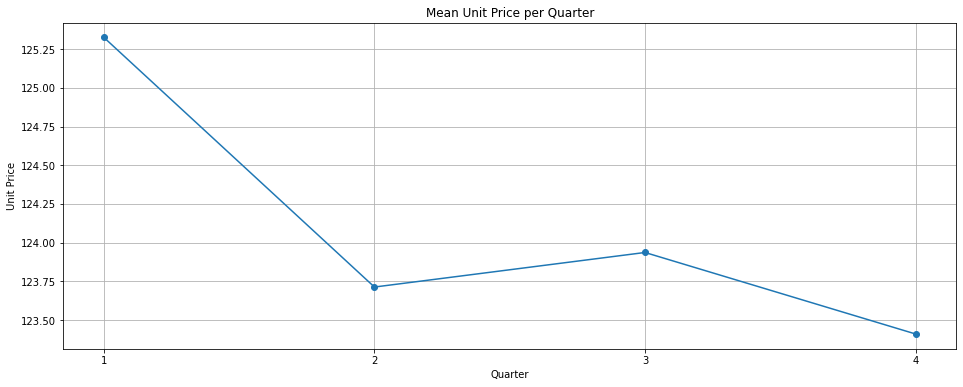

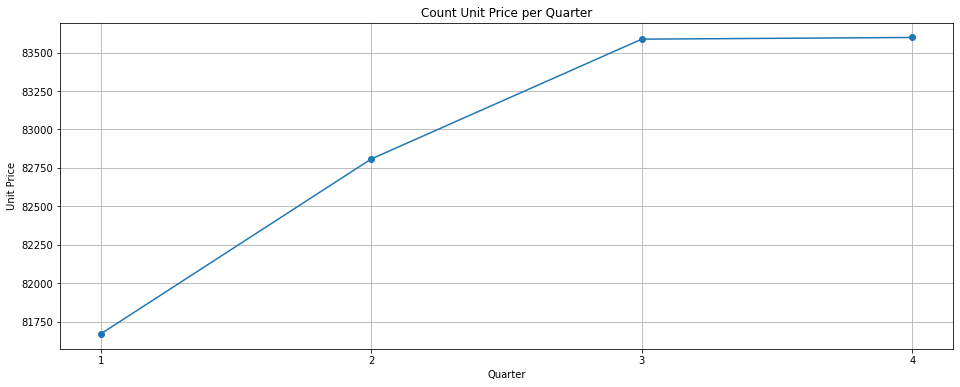

In [16]:
eda_plot(df, 'Quarter', 'Unit_Price', measurement='mean')
eda_plot(df, 'Quarter', 'Unit_Price', measurement='count')

#### A) Analysis:
1. There are variation in average unit price for all quarters are very minimal (2 dollars range).
2. There are more transactions during Q3 and Q4.

#### B) Evaluation:
There can be an argument that there are lesser customers during Q1 due to higher prices. To validate this assumption, I need to delve deeper.

#### C) Further Investigation:

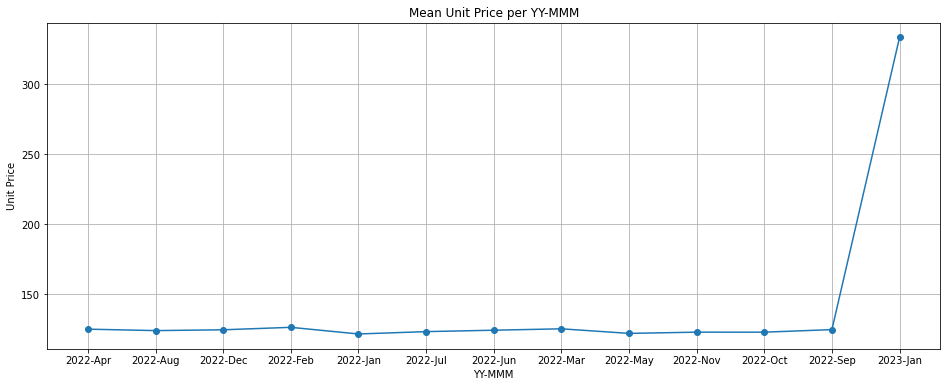

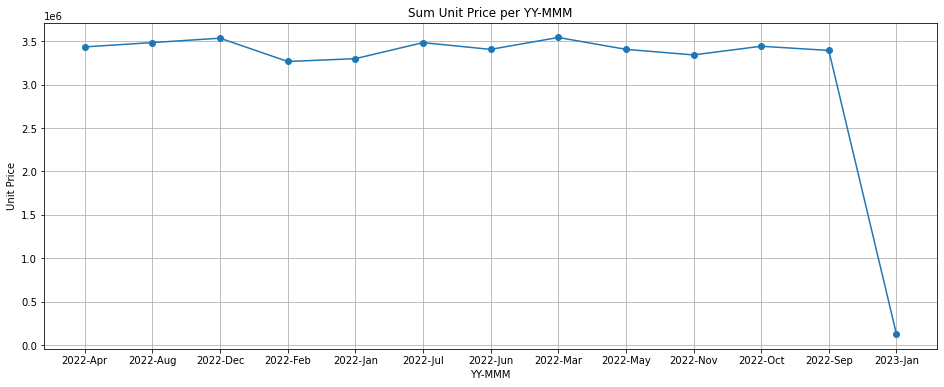

In [17]:
# Create the 'YY-MMM' column
df['YY-MMM'] = df['Datetime'].dt.strftime('%Y-%b')
eda_plot(df, 'YY-MMM', 'Unit_Price', measurement='mean')
eda_plot(df, 'YY-MMM', 'Unit_Price', measurement='sum')

#### D) Conclusion:
- Higher prices can significantly deter customers from engaging with purchases as proven by 2023-Jan.
- Quarter is quite a weak predictor.
- Drilling down to months, month may seem be a useful predictor. However, the dataset only has 1 year worth of data which is insufficient for validating if the trends for each month will be consistent or will change for every year. There is no way to prove useful for month as predictor due to lack of data.

#### 2.4.4 Relationship between quantity and quality
- Do customers prefer cheaper products?

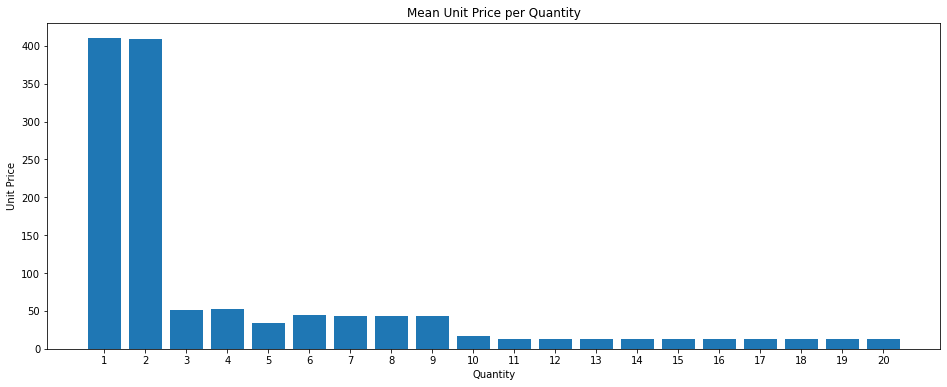

In [18]:
eda_plot(df, 'Quantity', 'Unit_Price', 'bar', measurement='mean')

#### A) Analysis:
- Each transaction can have a quantity of 1 to 20 of a product.
- Customers usually only buy 1-2 of an expensive product, but buy cheaper products less than 50 dollars in bulk.

#### B) Evaluation:
Discounts isn't the explanation for customers to buy more of a product as a discount of 88% (350/400) is illogical. 

#### C) Conclusion:
- Quantity is a potential predictor because there is a distinguishable pattern.
- My hypothesis is that the product is the most significant determiner for the price. To validate this assumption, I shall perform EDA for Product Category.

#### 2.4.5 Price of products across categories

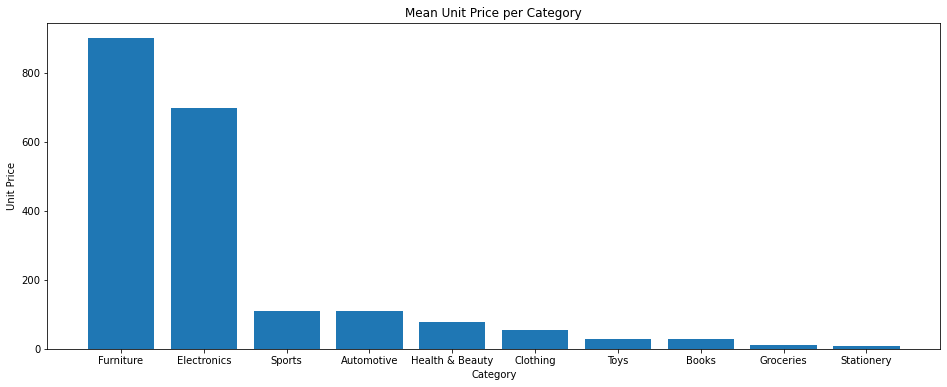

In [19]:
eda_plot(df, 'Category', 'Unit_Price', 'bar', 'mean')

#### A) Analysis
It's clear that Furniture an Electronic products are significantly more expensive on average.

#### B) Evaluation
- Examining prices per categories, the previous visualizations makes sense now. Customers tend to purchase multiple units of stationery, groceries, and toys, while they typically buy only one or two pieces of furniture or electronic devices at a time.
- A potential concern is that there may be low-cost items like earpieces within the electronics category. To address this, a robust feature is needed to distinguish affordable products within expensive categories or vice versa.
- It's worth noting that there may be multicollinearity between the quantity of items purchased and the product category as the bar graph trends explain each other.

#### C) Conclusion
Category is a useful predictor because there is an observable and logical pattern.

#### 2.4.6 Exploring relationship between Category and Product_ID
From 2.4.1, I discovered that the first 4 digits could represent something. To clarify my assumption, I shall investigate through visualisation.

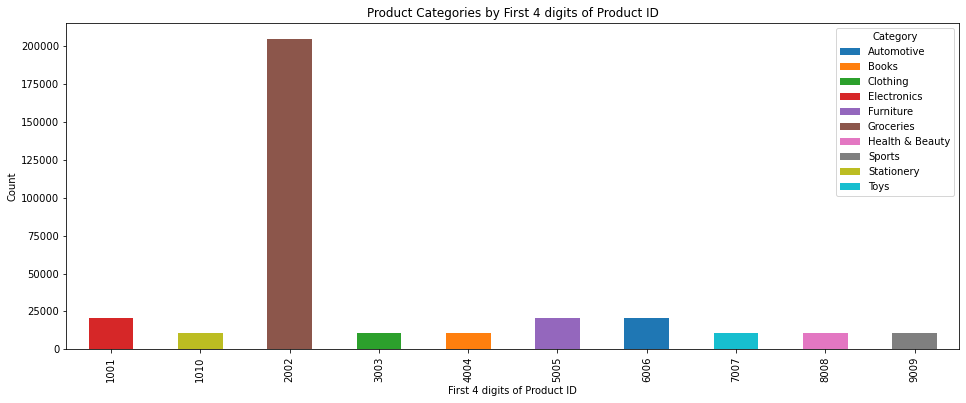

In [20]:
# Extract the first digit from 'Product_ID' and create a new column 'First_Digit'
df['4_digits'] = df['Product_ID'].astype(str).str[0:4]

# Group data by 'First_Digit' and 'Category' and count the occurrences
grouped = df.groupby(['4_digits', 'Category']).size().unstack(fill_value=0)

# Create a bar plot to visualize the relationship
grouped.plot(kind='bar', stacked=True, figsize=(16, 6))
plt.title("Product Categories by First 4 digits of Product ID")
plt.xlabel("First 4 digits of Product ID")
plt.ylabel("Count")
plt.show()

In [21]:
df.Product_ID.nunique() # count of distinct values

75781

#### A) Analysis
First 4 digits of Product ID represents the category.

#### B) Evaluation
There is no anomalous products.
There are too many product IDs; high cardinality column.

#### C) Conclusion
Do not use Product ID as it could overfit model due to high cardinality.

#### 2.4.7 Customer analysis
- I suspect a similar pattern with Customer ID where Retail Hypermarket labels their customer and puts the customer type as the header of the ID. Hence, I investigated each customer class.

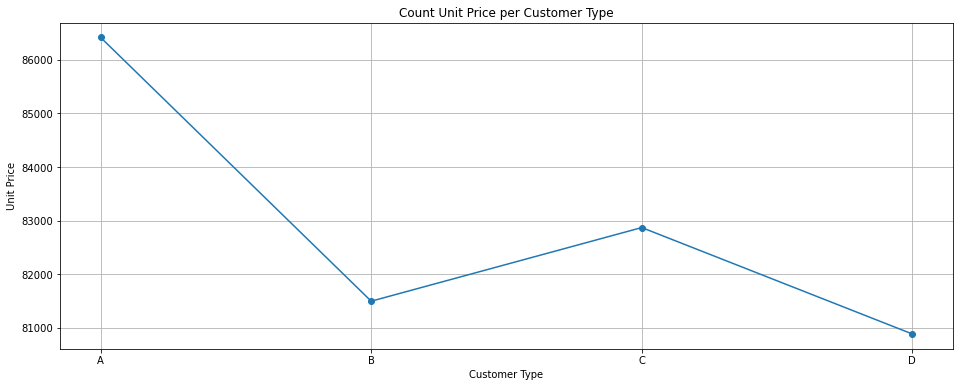

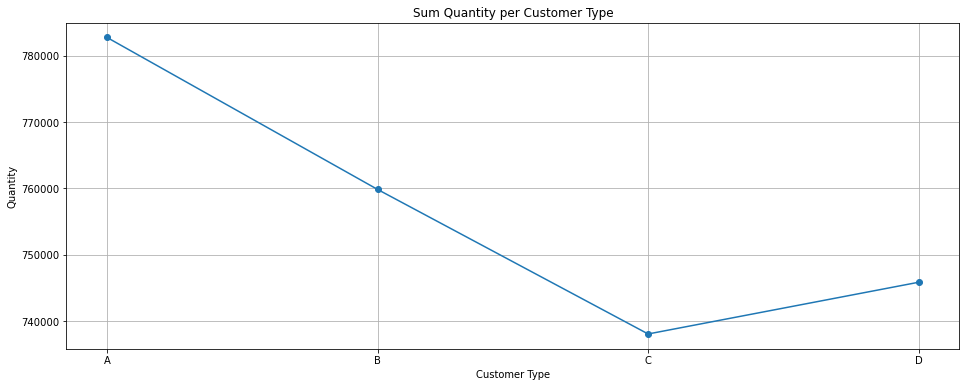

In [22]:
# Extract the first letter from 'Customer_ID' and create a new column 'Customer_Type'
df['Customer_Type'] = df['Customer_ID'].str[0].str.capitalize()

eda_plot(df, 'Customer_Type', 'Unit_Price', 'line', 'count')
eda_plot(df, 'Customer_Type', 'Quantity', 'line', 'sum')

In [23]:
df['Customer_Type'].value_counts()

A    86417
C    82869
B    81495
D    80883
Name: Customer_Type, dtype: int64

#### A) Analysis
- Around 80K customers for each customer type; no class imbalance in customer type.
- First letter of Product ID represents the customer class.
- There is a discernable pattern between Customer Type and the quantity of products they buy.

#### B) Evaluation
- Type A customers are clearly the most loyal group of customers who frequent Retail Hypermarket and buy the most products, while type C customers buy the least products. D seems to represent customers who are not yet grouped.

#### C) Conclusion
- Customers are grouped based on how much products they buy, customers who buy a lot are valued higher with A type, and customers who buys few products are labelled as C. D represents new customers who are yet to be assigned into a group.
- Type A customers are the best customers in loyalty and buying the most products.
- Customer Type has interesting trends, and could be a useful predictor for models to study the intricate patterns of each customer type.

### 2.5 Features Selection

#### 2.5.1 Shortlisted features:
1. Quantity
2. Category
3. Customer_Type

#### 2.5.2 Correlation Test

#### A) Pearsons Correlation: Ratio-Ratio

In [24]:
corr_matrix = df.drop(columns=['Product_ID']).corr()[:1] # pearsons correlation
corr_matrix

,Quantity,Unit_Price
Quantity,1.000,-0.465


#### Analysis:
There is a moderately strong inverse relationship between quantity and unit price.

#### Conclusion:
Quantity is a useful feature for predicting unit price.

#### B) One-way ANOVA: Nominal-Ratio

#### Function for ANOVA:

In [25]:
from scipy.stats import f_oneway

def oneway_anova(df, target, features):
    for feature in features:
        groups = []

        # for current feature, check its relationship with the target
        for category, group_df in df.groupby(feature):
            groups.append(group_df[target])

        # extracting p value from oneway ANOVA by passing all categorical columns
        f_value, p_value = f_oneway(*groups)
        print(f"ANOVA FOR {feature}: p-value = {p_value:.12f}")

#### ANOVA Test:
#### Hypotheses:
> H0: There is no significant difference between the feature and target columns.

> H1: There is significant difference between the feature and target columns.

#### Interpretation:
Null hypothesis assumes that all category means are equal.

If p-value < 0.05, reject H0. Else H0

In [26]:
oneway_anova(df, 'Unit_Price', ['Quarter', 'Category', 'Customer_Type'])

ANOVA FOR Quarter: p-value = 0.491363868713
ANOVA FOR Category: p-value = 0.000000000000
ANOVA FOR Customer_Type: p-value = 0.000000000000


#### Analysis:
As proven by statistics:
> The means of Quarter and unit price have no significant difference. This suggests collinearity between them, rendering Quarter to be a useless predictor to predict unit price. Hence its justified to reject this feature.

> Category and Customer_Type have significant difference with target, suggesting usefulness as predictors as there is a pattern to capture.

#### 2.5.3 Reject:
1. Quarter:
- No meaningful or distinguishable pattern between quarters.
- Statistically proven to be insignificant predictor due to collinearity with target.
2. Month:
- Weak trend as the only variation is an outlier month in 2022.
- Too little data to learn and validate market trend for each month as only 2021 is a completed year.
3. Product_ID:
- High cardinality, prone to overfit.
- Model wouldn't be usable for new Product IDs, failing business requirements.

## 3. Modelling
### 3.0 Reusable Methods

#### 3.0.1 Importing libraries

In [27]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import tree
import numpy as np

#### 3.0.2 Partitioner
To split dataset into train-test sets

#### Usage:
Provide DataFrame, target column, train size, and whether the predictors should be normalized for interepretability.

In [28]:
def partition(X, y, train_size=0.7, SEED=SEED, normalize=True):
    if normalize:
        scaler = StandardScaler()   # init scaler
        X = scaler.fit_transform(X) 

    # Split the normalized data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=SEED) # SEED = 2202934

    return X_train, X_test, y_train, y_test

#### 3.0.3 Model Evaluator
Report on model's fit and how predictors explain prediction.

#### Usage:
Provide the trained model, Predictors DataFrame, Target DataFrame, original Predictors DataFrame (to obtain column names), are you evaluating with model's training dataset? [True/False] default=False, max_depth=[display branches to which level].

In [29]:
def evaluate_model(model, X, y, cols, training=False, max_depth=3):
    y_pred = model.predict(X)  # Predict using the model and predictors
    
    # Only runs for Linear Regression, when intercept_ is found in model
    if hasattr(model, 'intercept_') and training:                                          # ONLY run for training evaluation 
        print(f"Intercept: {model.intercept_:.2f}")                                        # print intercept
        print(pd.DataFrame(model.coef_, cols.columns, columns=["Coefficient"]))            # print col name: value
            
    # for black-box models like DTR
    elif hasattr(model, 'feature_importances_') and training:
        # visualize Tree
        plt.figure(figsize=(16,20))
        tree.plot_tree(model, feature_names=list(X_train.columns), max_depth=max_depth, filled=True, fontsize=10)
            
    elif hasattr(model, 'intercept_') or hasattr(model, 'feature_importances_'):
        pass  # if testing set, no need to report on features
    
    # catch error
    else:
        print("Model type not supported for obtaining coefficients or feature importance.")
    
    
    # Visualize the fit
    plt.figure(figsize=(16, 6))
    plt.scatter(y, y_pred, alpha=0.2)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs Predicted Values")
    plt.grid(True)
    plt.show()
    
    print(f"R-squared (Goodness of Fit): {r2_score(y, y_pred):.2f}")

#### 3.0.4 Accuracy Evaluator
Creates relevant assessments to report on a model's performance.

#### Usage:
Provide the trained model, Predictors DataFrame, Target DataFrame, sample size for visualization.

In [30]:
def evaluate_accuracy(model, X, y, sample_size=0):
    y_pred = model.predict(X)  # Predict using the model and predictors
    
    # formula to calculate MAPE
    n = len(y)
    mape = (1/n) * sum(abs((y - y_pred) / y) * 100)
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    
    # Visualize Accuracy
    if sample_size > 0:
        y = y.iloc[:sample_size]
        y_pred = y_pred[:sample_size]
        
    else:
        return
    
    print("Sampled Analysis:")
    plt.figure(figsize=(16, 6))
    plt.plot(y.reset_index(drop=True), "red", label='Actual Data')
    plt.plot(y_pred, 'blue', label='Predicted Data', alpha=0.5)
    
    plt.ylabel('Unit_Price')
    plt.title('Actual Vs Predicted')
    plt.legend()
    plt.show()
    
    # formula to calculate MAPE
    n = len(y)
    mape = (1/n) * sum(abs((y - y_pred) / y) * 100)
    
    print(f"MAPE for sample: {mape:.2f}%")

### 3.1 Data Pre-processing
#### 3.1.0 One-Hot Encoders 
This encoding method is chosen as it makes the model highly interpretable as I know exactly how a prediction is derived.

In [31]:
# One-Hot Encoding
def one_hot_encode(df, columns_to_encode):
    one_hot = pd.get_dummies(df[columns_to_encode])         # Create new col for each unique value in encoded column
    df = pd.concat([df, one_hot], axis=1)                   # Concatenate encoded columns with the original DataFrame
    df = df.drop(columns=columns_to_encode)                 # Drop cols after encoded
    
    return df

Input: DataFrame, [encode_col1, encode_col2]

#### 3.1.1 Extract relevant features for Model's DataFrame:

In [32]:
# Subset a predictors and Target into DataFrames for modelling
X = df[['Quantity', 'Category', 'Customer_Type']]
y = df['Unit_Price']

#### 3.1.2 Encoding predictors

In [33]:
X = one_hot_encode(X, ['Category', 'Customer_Type'])

In [34]:
X.columns

Index(['Quantity', 'Category_Automotive', 'Category_Books',
       'Category_Clothing', 'Category_Electronics', 'Category_Furniture',
       'Category_Groceries', 'Category_Health & Beauty', 'Category_Sports',
       'Category_Stationery', 'Category_Toys', 'Customer_Type_A',
       'Customer_Type_B', 'Customer_Type_C', 'Customer_Type_D'],
      dtype='object')

#### 3.1.3 Data Partitioning
Splitting dataset into train-test sets where 70% of data is for training and 30% is for validation. Normalization not needed as all features are 0 or 1 except for quantity because their are derived from one-hot encoding. Hence, the model can be interpreted fairly without normalization.

In [35]:
X_train, X_test, y_train, y_test = partition(X, y, train_size=0.7, normalize=False)

### 3.2 Linear Regression

In [36]:
from sklearn.linear_model import LinearRegression
LR_model = LinearRegression()        # init model
LR_model.fit(X_train, y_train)       # train model

LinearRegression()

#### Evaluate Model explanability on training set:

Intercept: 200.71
                          Coefficient
Quantity                        0.287
Category_Automotive           -91.308
Category_Books               -173.960
Category_Clothing            -146.993
Category_Electronics          493.211
Category_Furniture            699.071
Category_Groceries           -192.825
Category_Health & Beauty     -124.743
Category_Sports               -92.059
Category_Stationery          -195.757
Category_Toys                -174.638
Customer_Type_A                -0.279
Customer_Type_B                -0.062
Customer_Type_C                 0.383
Customer_Type_D                -0.042


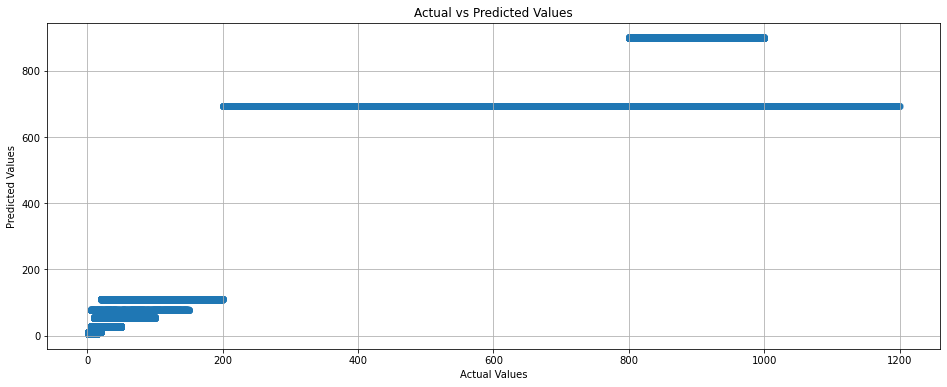

R-squared (Goodness of Fit): 0.92


In [37]:
evaluate_model(LR_model, X_train, y_train, X, training=True) 
# Model, training predictors, training targets, predictors, isTraining

#### Model performance on training set:

In [38]:
evaluate_accuracy(LR_model, X_train, y_train)

Mean Absolute Percentage Error (MAPE): 44.08%


#### Evaluate Model explanability on testing set:

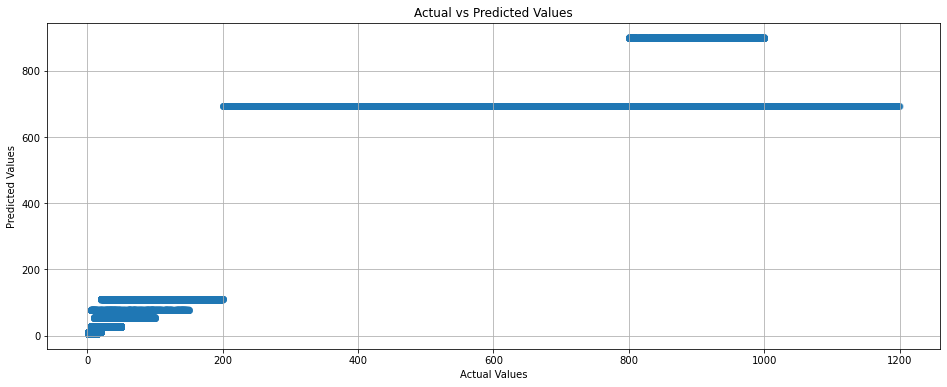

R-squared (Goodness of Fit): 0.92


In [39]:
evaluate_model(LR_model, X_test, y_test, X)

#### Model performance on training set:

Mean Absolute Percentage Error (MAPE): 44.12%
Sampled Analysis:


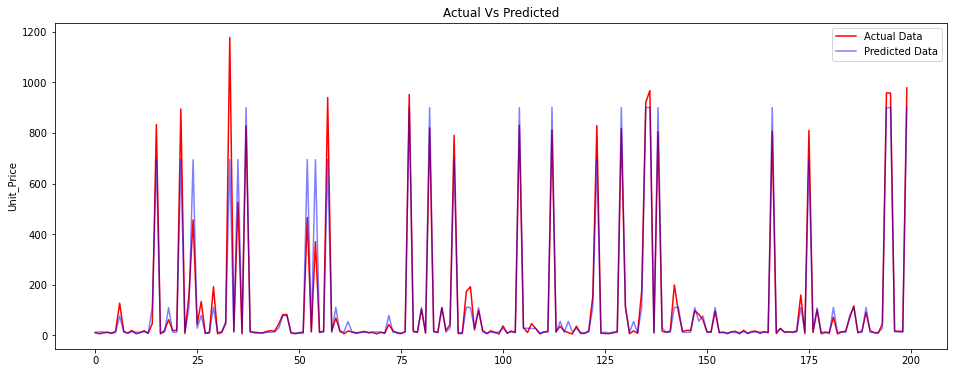

MAPE for sample: 37.71%


In [40]:
evaluate_accuracy(LR_model, X_test, y_test, sample_size=200) # edit sample_size to explore

### 3.3 Decision Tree Regression

In [41]:
#Build DTR model
from sklearn.tree import DecisionTreeRegressor
DTR_model = DecisionTreeRegressor(random_state=SEED).fit(X_train , y_train) # train model

#### Evaluate Model explanability on training set:

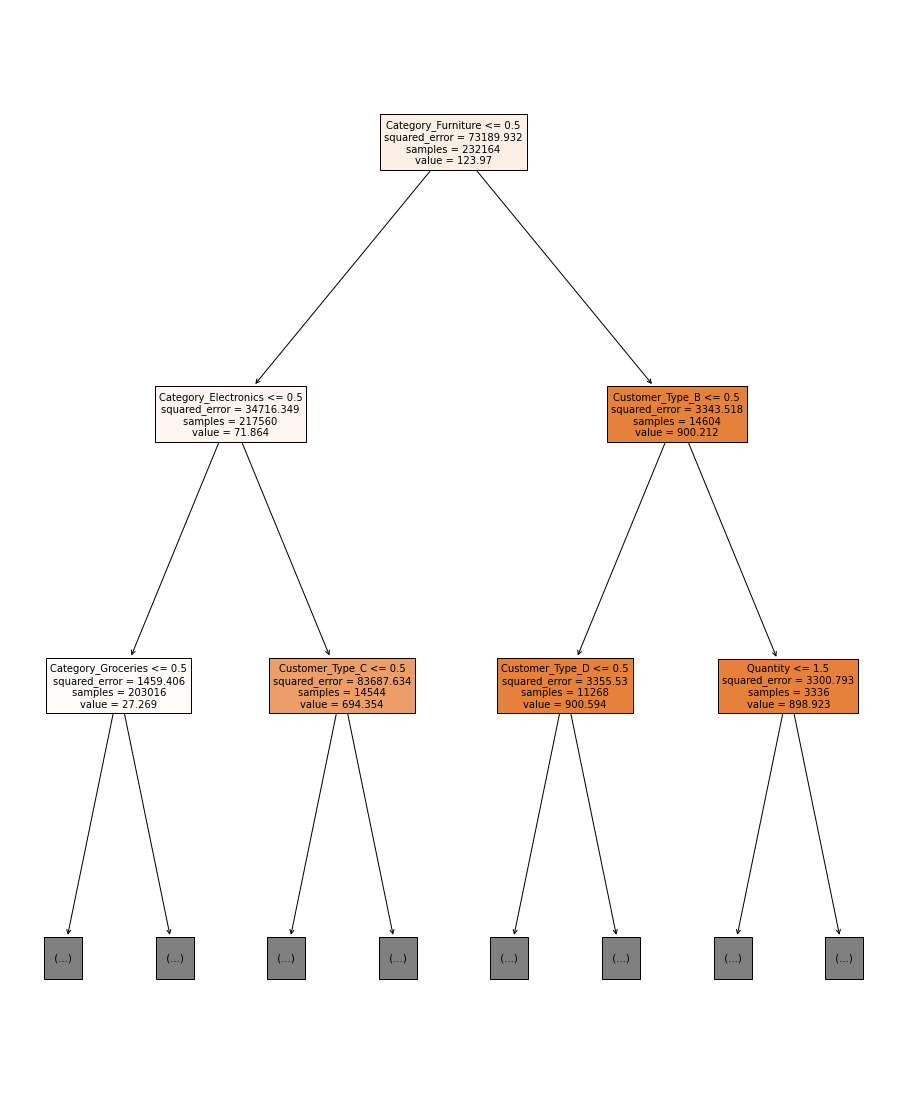

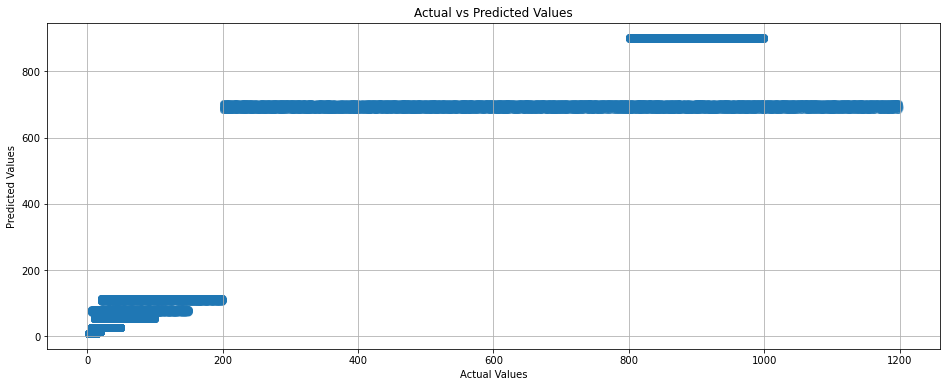

R-squared (Goodness of Fit): 0.92


In [42]:
evaluate_model(DTR_model, X_train, y_train, X, training=True, max_depth=2)

#### Model performance on training set:

In [43]:
evaluate_accuracy(DTR_model, X_train, y_train)

Mean Absolute Percentage Error (MAPE): 43.20%


#### Evaluate Model explanability on testing set:

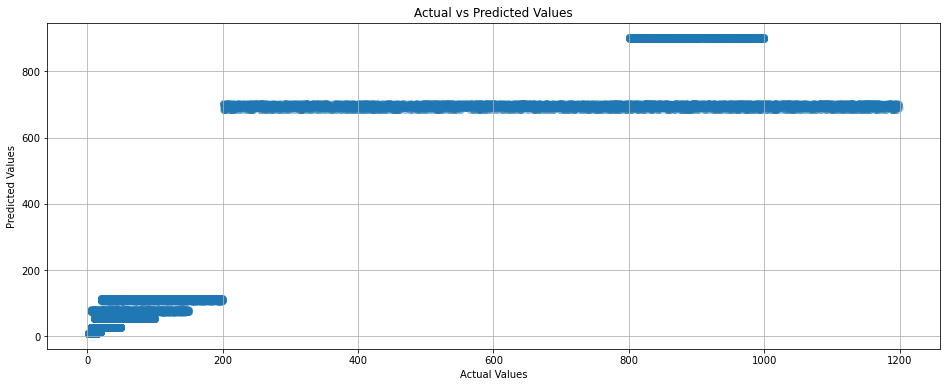

R-squared (Goodness of Fit): 0.92


In [44]:
evaluate_model(DTR_model, X_test, y_test, X)

#### Model performance on training set:

Mean Absolute Percentage Error (MAPE): 43.34%
Sampled Analysis:


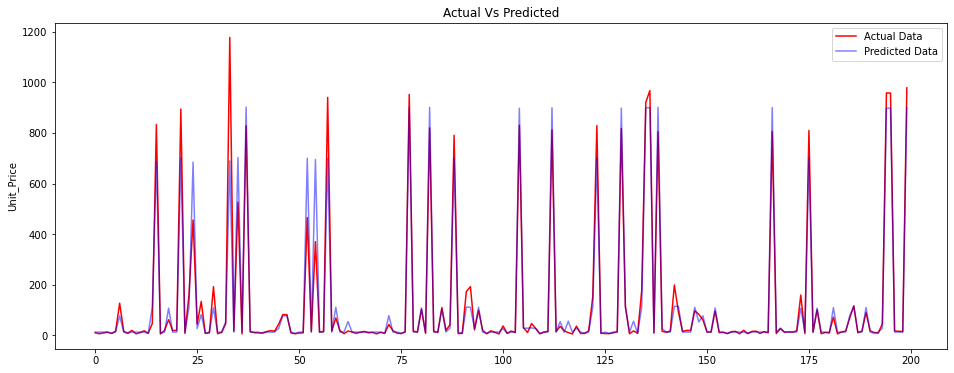

MAPE for sample: 36.54%


In [45]:
evaluate_accuracy(DTR_model, X_test, y_test, sample_size=200) # edit sample_size to explore

### References for part 1:
- 1.0 Problem Framing: Creating Week 03 Workshop 05: Problem Framing. Temasek Polytechnic. 
- 1.6 Metrics for evaluating models. Week 02 Workshop 04: Model Scoring
- 1.8 Considering environmental factors: Ideas were improved upon suggestions from ChatGPT.
- 1.9 Formulating potential Target Leakages, Week 03 Workshop 06: Target Leakage
- 2.1 Data Dictionary is taken from project specifications.
- 2.4.2 EDA Graph Plotter is built with ChatGPT. OpenAI. (2023, October 30). Re: Python Code for Creating Line and Bar Plots in EDA [Online Forum Comment]. ChatGPT by OpenAI. https://www.chatgpt.com
- 2.4.6 Graph of Total Revenue per Product is adapted from ChatGPT's code. OpenAI. (2023, October 30). Re: Python Code for Creating Line and Bar Plots in EDA [Online Forum Comment]. ChatGPT by OpenAI. https://www.chatgpt.com
- 2.5.2.B One-way ANOVA function code is taken from Lab_P04_TooGoodToBeTrue. Temasek Polytechnic.
- 3.0 Reusable methods are built with ChatGPT. OpenAI. (2023, October 31).
- 3.0.3 Coefficient of predictors table adapted from P01_RecapML 4.4 Model Interpretation#Coefficients. Temasek Polytechnic.
- 3.0.4 Sampled analysis graph is adapted from P01_RecapML 4.4 Model Interpretation#Plot of y_pred and y_test. Temasek Polytechnic.
- 3.1.0 One-Hot encoder built with ChatGPT. OpenAI. (2023, October 31). Re: # One-Hot Encoding
def one-hot(): // create a one-hot encoder function. input: df, columns to be encoder [Online Forum Comment]. ChatGPT by OpenAI. https://www.chatgpt.com
- 3.3 Code to visualize Decision Tree Regressor is taken from Lab P02_TreeBasedAlgorithm#2.4 Limitations of DT#Method 2 